# Data processing notebook
author: Gonzalo Miranda Cabrera

objective: create a clean dataset with the provided data tables for later training of ml models.

summary:
1. cleaning tables: process each table and get it ready for a join into one dataset.
2. join tables: combine the tables into one.
3. features: add more features to the dataset. (correlation matrix and rates between preexisting columns)
4. Split Nan for submission: save rows with total_minutes with nan values for submission file.
5. outliers: remove rows that have total_minutes or distance too high.
6. write csv: save data and submission to disk.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
import numpy as np
from geopy.distance import distance


In [2]:
order_products = pd.read_csv('data/order_products.csv')
orders = pd.read_csv('data/orders.csv')
shoppers = pd.read_csv('data/shoppers.csv')
storebranch = pd.read_csv('data/storebranch.csv')

## Cleaning tables

### order_products table


In [3]:
order_products.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [4]:
# Aggregate total units and total kgs per order
total_order_products = (
    order_products.groupby(["order_id", "buy_unit"]).sum().reset_index()
)
total_order_products.head(7)


,order_id,buy_unit,quantity
0,0004a3841c1eeb6c6e77585a941c21e0,UN,8.000
1,0005a6ecbbde1e8d273f5577bcff2c9c,UN,2.000
2,0007baeb6700fc203be2d1f1e11222d7,UN,39.000
3,0012195a6a8ca9ec308a3010eeea8ebc,UN,13.000
4,0013011fa72b498b9feb84f4e7104980,KG,1.636
5,0013011fa72b498b9feb84f4e7104980,UN,63.000
6,00163fe640579e995cbfcf7c686bdb05,UN,33.000


In [5]:
# Calculate the amount of unique products per order
unique_products = (
    order_products.groupby(["order_id"])['product_id'].count().reset_index()
)
unique_products.head(7)

,order_id,product_id
0,0004a3841c1eeb6c6e77585a941c21e0,4
1,0005a6ecbbde1e8d273f5577bcff2c9c,1
2,0007baeb6700fc203be2d1f1e11222d7,22
3,0012195a6a8ca9ec308a3010eeea8ebc,11
4,0013011fa72b498b9feb84f4e7104980,44
5,00163fe640579e995cbfcf7c686bdb05,16
6,002bd365a1c22ef190498efd95dd4c4c,1


In [6]:
# Leave only unique order_id on order_products table
order_products.drop_duplicates(subset=['order_id'], inplace=True)
order_products.drop(columns=['product_id', 'quantity', 'buy_unit'], inplace=True)
order_products.head()

,order_id
0,47099653730fb1b76537fc10ad876255
1,689d8866915acf87e851c2591a23a82f
2,f26d16bf6f38c9e31d0be877f4013a9e
3,161ccc896835ab41761b0e726becb6b1
4,4713deca10bb5db98fae150b52d61fc0


In [7]:
# Add unique products per order to order_products table
order_products = (
    order_products.set_index("order_id")
    .join(unique_products.set_index("order_id"))
    .reset_index()
)
order_products.rename(columns={"product_id": "unique_products"}, inplace=True)
order_products.head()

,order_id,unique_products
0,47099653730fb1b76537fc10ad876255,33
1,689d8866915acf87e851c2591a23a82f,26
2,f26d16bf6f38c9e31d0be877f4013a9e,27
3,161ccc896835ab41761b0e726becb6b1,16
4,4713deca10bb5db98fae150b52d61fc0,48


In [8]:
# Add total units per order_id
filter_ = total_order_products["buy_unit"] == "UN"
order_products = (
    order_products.set_index("order_id")
    .join(total_order_products[filter_][["order_id", "quantity"]].set_index("order_id"))
    .reset_index()
)
order_products.rename(columns={"quantity": "units"}, inplace=True)
order_products.head()


,order_id,unique_products,units
0,47099653730fb1b76537fc10ad876255,33,44.0
1,689d8866915acf87e851c2591a23a82f,26,34.0
2,f26d16bf6f38c9e31d0be877f4013a9e,27,35.0
3,161ccc896835ab41761b0e726becb6b1,16,20.0
4,4713deca10bb5db98fae150b52d61fc0,48,116.0


In [9]:
# Add total kgs per order_id
filter_ = total_order_products["buy_unit"] == "KG"
order_products = (
    order_products.set_index("order_id")
    .join(total_order_products[filter_][["order_id", "quantity"]].set_index("order_id"))
    .reset_index()
)
order_products.rename(columns={"quantity": "kgs"}, inplace=True)
order_products.head(30)


,order_id,unique_products,units,kgs
0,47099653730fb1b76537fc10ad876255,33,44.0,12.700
1,689d8866915acf87e851c2591a23a82f,26,34.0,2.300
2,f26d16bf6f38c9e31d0be877f4013a9e,27,35.0,0.240
3,161ccc896835ab41761b0e726becb6b1,16,20.0,3.235
4,4713deca10bb5db98fae150b52d61fc0,48,116.0,0.300
5,742c8318bd4b691ef21517372e12eb14,30,45.0,2.500
6,4bf1d742d2aaa747c8e42074306776c6,6,8.0,0.400
7,a8b56b2aba8e0c2609b1e70fff2c1951,14,25.0,0.885
8,63d745ef282dfeee0a89b5c8e4e79acb,34,65.0,1.300
9,bea1786439523ef6973ec8395231e713,19,51.0,2.776


In [10]:
# Fill NaN values of order_products table
order_products.fillna(0, inplace=True)

del filter_, total_order_products, unique_products

order_products.head(30)


,order_id,unique_products,units,kgs
0,47099653730fb1b76537fc10ad876255,33,44.0,12.700
1,689d8866915acf87e851c2591a23a82f,26,34.0,2.300
2,f26d16bf6f38c9e31d0be877f4013a9e,27,35.0,0.240
3,161ccc896835ab41761b0e726becb6b1,16,20.0,3.235
4,4713deca10bb5db98fae150b52d61fc0,48,116.0,0.300
5,742c8318bd4b691ef21517372e12eb14,30,45.0,2.500
6,4bf1d742d2aaa747c8e42074306776c6,6,8.0,0.400
7,a8b56b2aba8e0c2609b1e70fff2c1951,14,25.0,0.885
8,63d745ef282dfeee0a89b5c8e4e79acb,34,65.0,1.300
9,bea1786439523ef6973ec8395231e713,19,51.0,2.776


### Orders table

In [11]:
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [12]:
orders.isna().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      2000
dtype: int64

In [13]:
# Check the days, month and years that the orders took place
orders['promised_time'] = pd.to_datetime(orders['promised_time'])
orders.promised_time.dt.day.unique(), orders.promised_time.dt.month.unique(), orders.promised_time.dt.year.unique()

(array([18, 19, 20]), array([10]), array([2019]))

In [14]:
# Create one-hot encoded columns for the days
orders['day'] = orders.promised_time.dt.day_name()
orders = pd.concat(
    [orders, pd.get_dummies(orders.day, prefix="is")], axis=1
)
orders.drop(columns=['promised_time', 'day'], inplace=True)

In [15]:
# Create delivery_point for distance calculation with stores
orders["delivery_point"] = list(zip(orders.lat, orders.lng))
orders.drop(columns=["lat", "lng"], inplace=True)

# Covnert bool to int
orders["on_demand"] = orders["on_demand"].astype(int)
orders.head()


,order_id,on_demand,shopper_id,store_branch_id,total_minutes,is_Friday,is_Saturday,is_Sunday,delivery_point
0,e750294655c2c7c34d83cc3181c09de4,1,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,1,0,0,"(-33.5016745551528, -70.5793685999999)"
1,6581174846221cb6c467348e87f57641,0,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0,1,0,"(-33.4405840012576, -70.5562828195387)"
2,3a226ea48debc0a7ae9950d5540f2f34,1,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0,1,0,"(-32.987022410412, -71.5448421143012)"
3,7d2ed03fe4966083e74b12694b1669d8,1,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,1,0,0,"(-33.3280747609911, -70.5126585573593)"
4,b4b2682d77118155fe4716300ccf7f39,0,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0,1,0,"(-33.4032392, -70.5640197)"


### Shoppers table

In [16]:
shoppers.head()


,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [17]:
shoppers.isna().sum()

shopper_id         0
seniority          0
found_rate       101
picking_speed      0
accepted_rate     27
rating            84
dtype: int64

In [18]:
# Fill NaN with mean of each column
shoppers.fillna(shoppers.mean(), inplace=True)

In [19]:
shoppers.isna().sum()

shopper_id       0
seniority        0
found_rate       0
picking_speed    0
accepted_rate    0
rating           0
dtype: int64

In [20]:
# Convert seniority categorical to one hot encoding
shoppers = pd.concat(
    [shoppers, pd.get_dummies(shoppers.seniority, prefix="seniority")], axis=1
)
shoppers.drop(columns=["seniority"], inplace=True)

shoppers.head()


,shopper_id,found_rate,picking_speed,accepted_rate,rating,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,0.860600,1.94,1.000000,4.870000,1,0,0,0
1,e1c679ac73a69c01981fdd3c5ab8beda,0.844600,1.23,0.920000,4.920000,0,0,1,0
2,09d369c66ca86ebeffacb133410c5ee1,0.855900,1.56,1.000000,4.880000,0,0,1,0
3,db39866e62b95bb04ebb1e470f2d1347,0.861082,2.41,0.908276,4.848428,0,1,0,0
4,8efbc238660053b19f00ca431144fdae,0.877000,1.31,0.920000,4.880000,0,0,1,0


### Storebranch table

In [21]:
storebranch.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [22]:
# Create store_point for distance calculation with orders
storebranch["store_point"] = list(zip(storebranch["lat"], storebranch["lng"]))
storebranch.drop(columns=["lat", "lng", "store_id"], inplace=True)
storebranch.head()


,store_branch_id,store_point
0,aff1621254f7c1be92f64550478c56e6,"(-33.422497, -70.609231)"
1,56352739f59643540a3a6e16985f62c7,"(-33.385484, -70.555579)"
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,"(-33.416579, -70.565224)"
3,2b24d495052a8ce66358eb576b8912c8,"(-33.5125776, -70.6559515)"
4,5487315b1286f907165907aa8fc96619,"(-33.347645, -70.542229)"


## Join tables

In [23]:
orders.head()

,order_id,on_demand,shopper_id,store_branch_id,total_minutes,is_Friday,is_Saturday,is_Sunday,delivery_point
0,e750294655c2c7c34d83cc3181c09de4,1,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,1,0,0,"(-33.5016745551528, -70.5793685999999)"
1,6581174846221cb6c467348e87f57641,0,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0,1,0,"(-33.4405840012576, -70.5562828195387)"
2,3a226ea48debc0a7ae9950d5540f2f34,1,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0,1,0,"(-32.987022410412, -71.5448421143012)"
3,7d2ed03fe4966083e74b12694b1669d8,1,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,1,0,0,"(-33.3280747609911, -70.5126585573593)"
4,b4b2682d77118155fe4716300ccf7f39,0,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0,1,0,"(-33.4032392, -70.5640197)"


In [24]:
# Join orders and storebranch tables into data
data = (
    orders.set_index("store_branch_id")
    .join(storebranch.set_index("store_branch_id"))
    .reset_index()
)
data.drop(columns=["store_branch_id"], inplace=True)
data.head()


,order_id,on_demand,shopper_id,total_minutes,is_Friday,is_Saturday,is_Sunday,delivery_point,store_point
0,1736134188205cad9b1392e2f814a32e,0,96c3f31b67796e0c8b9b19b69edef899,31.571355,0,1,0,"(-32.9400445585011, -71.5205515942991)","(-32.933843, -71.530328)"
1,846a810f6fbdb3f0224deb0df7ecdc3f,0,86818c43263f77bc466b4cbcc417492f,47.918674,0,1,0,"(-33.3740532, -70.5452233)","(-33.382522, -70.535851)"
2,0fc72b50ab3631c981b8076d31d2ff8d,0,deff9a0142aae50ebd32e6ef78f847c8,37.679184,0,1,0,"(-33.4044538, -70.5558226)","(-33.382522, -70.535851)"
3,1c2add679796ebf1622a2027f2116010,0,c62fa64bbba97382f77b8c4a3c507fc4,33.331216,0,1,0,"(-33.3846664976598, -70.5618295487009)","(-33.3901, -70.587097)"
4,23f0cdcf4def0a5390c1e60400052c29,1,0cedb218332091e94623047ccb6f85ba,39.063608,1,0,0,"(-33.3937194, -70.578504)","(-33.3901, -70.587097)"


In [25]:
# Calculate distance from shopper to store
data["distance"] = data[["delivery_point", "store_point"]].apply(
    lambda values: distance(values[0], values[1]).kilometers, axis=1
)
data.drop(columns=["delivery_point", "store_point"], inplace=True)
data.head()


,order_id,on_demand,shopper_id,total_minutes,is_Friday,is_Saturday,is_Sunday,distance
0,1736134188205cad9b1392e2f814a32e,0,96c3f31b67796e0c8b9b19b69edef899,31.571355,0,1,0,1.144094
1,846a810f6fbdb3f0224deb0df7ecdc3f,0,86818c43263f77bc466b4cbcc417492f,47.918674,0,1,0,1.281733
2,0fc72b50ab3631c981b8076d31d2ff8d,0,deff9a0142aae50ebd32e6ef78f847c8,37.679184,0,1,0,3.060958
3,1c2add679796ebf1622a2027f2116010,0,c62fa64bbba97382f77b8c4a3c507fc4,33.331216,0,1,0,2.426962
4,23f0cdcf4def0a5390c1e60400052c29,1,0cedb218332091e94623047ccb6f85ba,39.063608,1,0,0,0.894599


In [26]:
# Join data and shoppers tables
data = (
    data.set_index("shopper_id").join(shoppers.set_index("shopper_id")).reset_index()
)
data.drop(columns=["shopper_id"], inplace=True)
data.head()


,order_id,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f
0,d8208f9d0d220440d8ed3273e9499357,0,69.248532,0,1,0,2.249269,0.861082,2.19,0.75,4.88,0,0,0,1
1,1c59fd2647355c522c60ed40ead7a27f,0,64.763995,0,1,0,2.072538,0.885400,1.58,0.84,4.52,0,1,0,0
2,67217ef6bc93f4f7c9045990298b58fb,0,NaN,0,1,0,1.061235,0.885400,1.58,0.84,4.52,0,1,0,0
3,fdfb71531fc7e9d31154f717d11e72ab,0,91.260757,0,1,0,1.610113,0.885400,1.58,0.84,4.52,0,1,0,0
4,5a621d9faf9a76679f1c3a75fdfda8a1,1,24.141767,0,1,0,1.290954,0.885400,1.58,0.84,4.52,0,1,0,0


In [27]:
# Join data and order_products tables
data = data.set_index("order_id").join(order_products.set_index("order_id"))
data.head()


,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,unique_products,units,kgs
order_id,,,,,,,,,,,,,,,,,
d8208f9d0d220440d8ed3273e9499357,0,69.248532,0,1,0,2.249269,0.861082,2.19,0.75,4.88,0,0,0,1,3.0,7.0,0.000
1c59fd2647355c522c60ed40ead7a27f,0,64.763995,0,1,0,2.072538,0.885400,1.58,0.84,4.52,0,1,0,0,14.0,22.0,2.164
67217ef6bc93f4f7c9045990298b58fb,0,NaN,0,1,0,1.061235,0.885400,1.58,0.84,4.52,0,1,0,0,72.0,130.0,12.666
fdfb71531fc7e9d31154f717d11e72ab,0,91.260757,0,1,0,1.610113,0.885400,1.58,0.84,4.52,0,1,0,0,25.0,43.0,7.360
5a621d9faf9a76679f1c3a75fdfda8a1,1,24.141767,0,1,0,1.290954,0.885400,1.58,0.84,4.52,0,1,0,0,1.0,2.0,0.000


In [28]:
data.isna().sum()

on_demand                                        0
total_minutes                                 2000
is_Friday                                        0
is_Saturday                                      0
is_Sunday                                        0
distance                                         0
found_rate                                       0
picking_speed                                    0
accepted_rate                                    0
rating                                           0
seniority_41dc7c9e385c4d2b6c1f7836973951bf       0
seniority_50e13ee63f086c2fe84229348bc91b5b       0
seniority_6c90661e6d2c7579f5ce337c3391dbb9       0
seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f       0
unique_products                                 22
units                                           22
kgs                                             22
dtype: int64

In [29]:
# order_ids in orders but not in order_products
data.drop(
    data[
        (data["units"].isna() | data["kgs"].isna()) | data["unique_products"].isna()
    ].index,
    inplace=True,
)
data.isna().sum()


on_demand                                        0
total_minutes                                 1995
is_Friday                                        0
is_Saturday                                      0
is_Sunday                                        0
distance                                         0
found_rate                                       0
picking_speed                                    0
accepted_rate                                    0
rating                                           0
seniority_41dc7c9e385c4d2b6c1f7836973951bf       0
seniority_50e13ee63f086c2fe84229348bc91b5b       0
seniority_6c90661e6d2c7579f5ce337c3391dbb9       0
seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f       0
unique_products                                  0
units                                            0
kgs                                              0
dtype: int64

In [30]:
data

,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,unique_products,units,kgs
order_id,,,,,,,,,,,,,,,,,
d8208f9d0d220440d8ed3273e9499357,0,69.248532,0,1,0,2.249269,0.861082,2.19,0.75,4.88,0,0,0,1,3.0,7.0,0.000
1c59fd2647355c522c60ed40ead7a27f,0,64.763995,0,1,0,2.072538,0.885400,1.58,0.84,4.52,0,1,0,0,14.0,22.0,2.164
67217ef6bc93f4f7c9045990298b58fb,0,NaN,0,1,0,1.061235,0.885400,1.58,0.84,4.52,0,1,0,0,72.0,130.0,12.666
fdfb71531fc7e9d31154f717d11e72ab,0,91.260757,0,1,0,1.610113,0.885400,1.58,0.84,4.52,0,1,0,0,25.0,43.0,7.360
5a621d9faf9a76679f1c3a75fdfda8a1,1,24.141767,0,1,0,1.290954,0.885400,1.58,0.84,4.52,0,1,0,0,1.0,2.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55b5a40bb41650e3f3d3a62aeb6685ee,1,42.213534,1,0,0,5.136666,0.893600,2.09,0.56,5.00,0,1,0,0,6.0,7.0,0.000
669b0209a6555e1999b9d7fcfb05a3f0,0,NaN,0,1,0,1.680601,0.893600,2.09,0.56,5.00,0,1,0,0,4.0,6.0,0.000
c0c96e45d682d51d6c3c8ce7ae5b9497,0,61.025106,0,1,0,1.515028,0.875700,1.22,0.92,4.96,0,0,1,0,19.0,30.0,1.469


In [31]:
del storebranch, shoppers, order_products, orders

## Features

<AxesSubplot:>

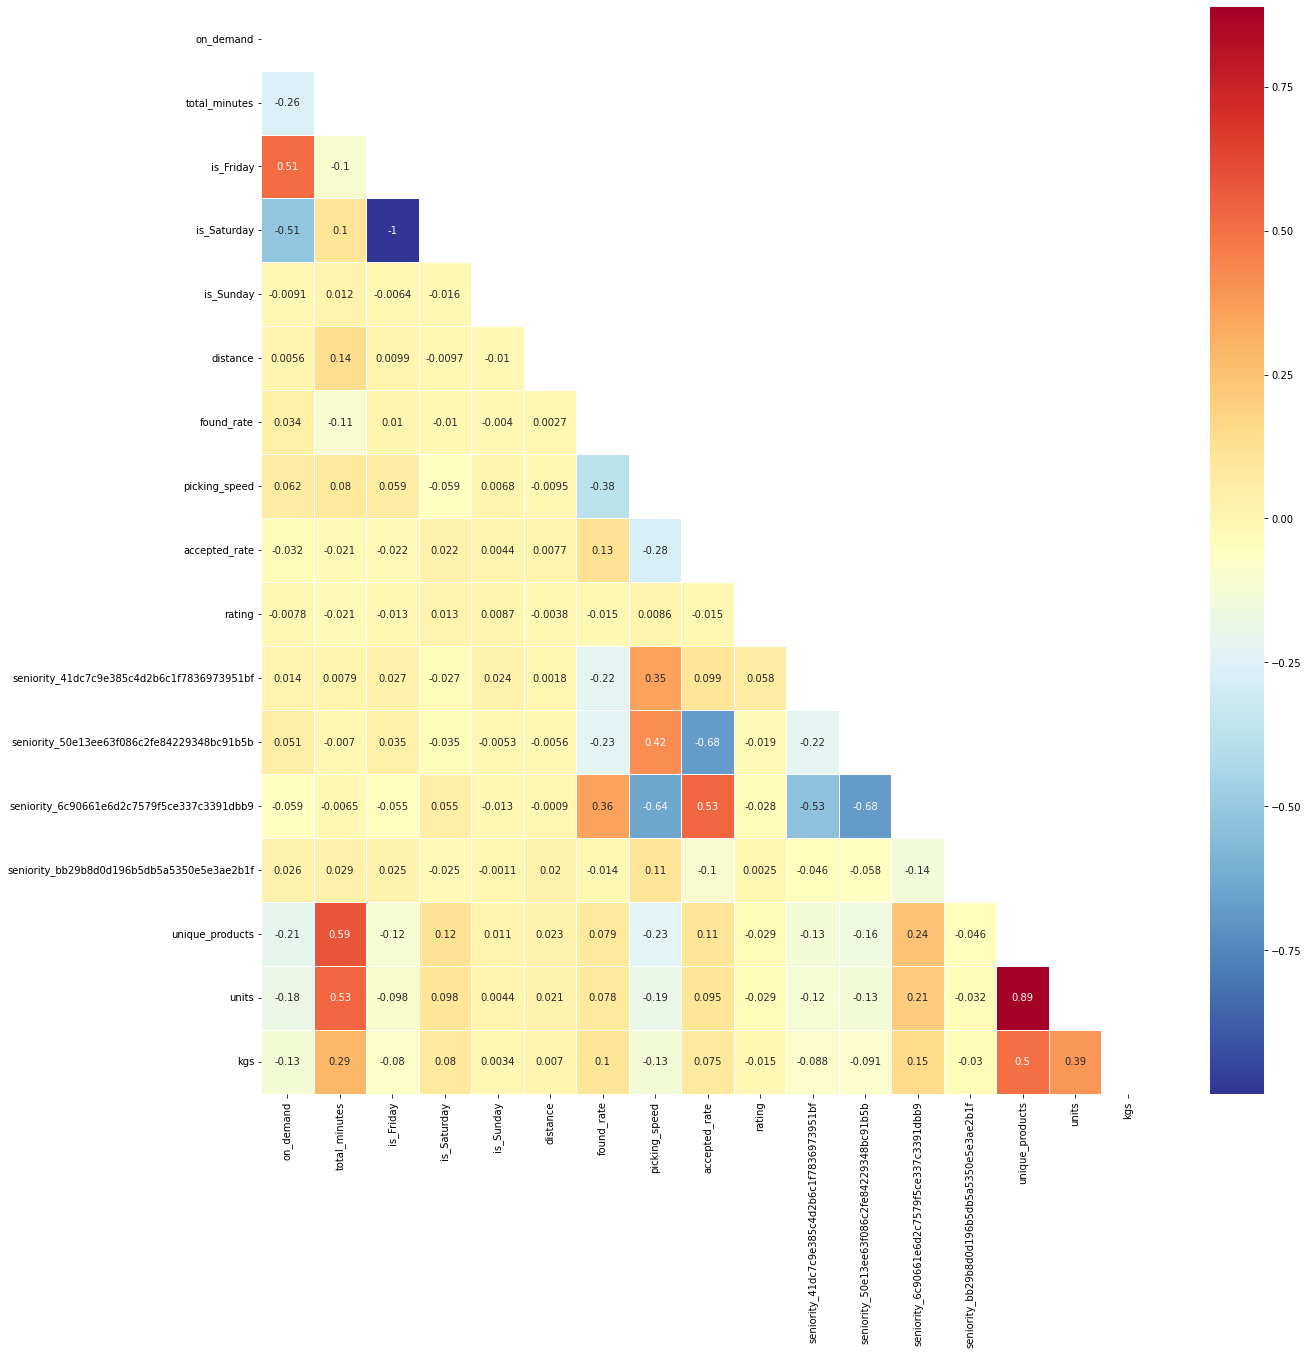

In [32]:
plt.figure(figsize=(20, 20))
heatmap(data.corr(), annot=True, linewidth=.8, mask=np.triu(data.corr()), cmap="RdYlBu_r")

unique_products, units and kgs are the features that have greater correlation with total_minutes


In [33]:
# create estimated order size assuming 1 kg is 1 unit
data['order_size'] = data.units + data.kgs

# scale features with math functions
data['root_order_size'] = np.sqrt(data.order_size)
data['sqrd_order_size'] = data.order_size**2
data['logn_order_size'] = np.log(data.order_size) 

data['root_units'] = np.sqrt(data.units)
data['sqrd_units'] = data.units**2
data['logn_units'] = np.log(data.units + 1)

data['root_kgs'] = np.sqrt(data.kgs)
data['sqrd_kgs'] = data.kgs**2
data['logn_kgs'] = np.log(data.kgs + 1)

data['root_unique_products'] = np.sqrt(data.unique_products)
data['sqrd_unique_products'] = data.unique_products**2
data['logn_unique_products'] = np.log(data.unique_products)

# Create different rates with distance
data['distance_div_units'] = np.true_divide(data.distance, data.units + 1)
data['distance_div_kgs'] = np.true_divide(data.distance, data.kgs + 1)
data['distance_div_unique_products'] = data.distance / data.unique_products
data['distance_div_order_size'] = data.distance / data.order_size

# Create different rates with picking speed
data['unique_products_div_picking_speed'] = data.unique_products / data.picking_speed
data['units_div_picking_speed'] = data.units / data.picking_speed
data['kgs_div_picking_speed'] = data.kgs / data.picking_speed
data['order_size_div_picking_speed'] = data.order_size / data.picking_speed


<AxesSubplot:>

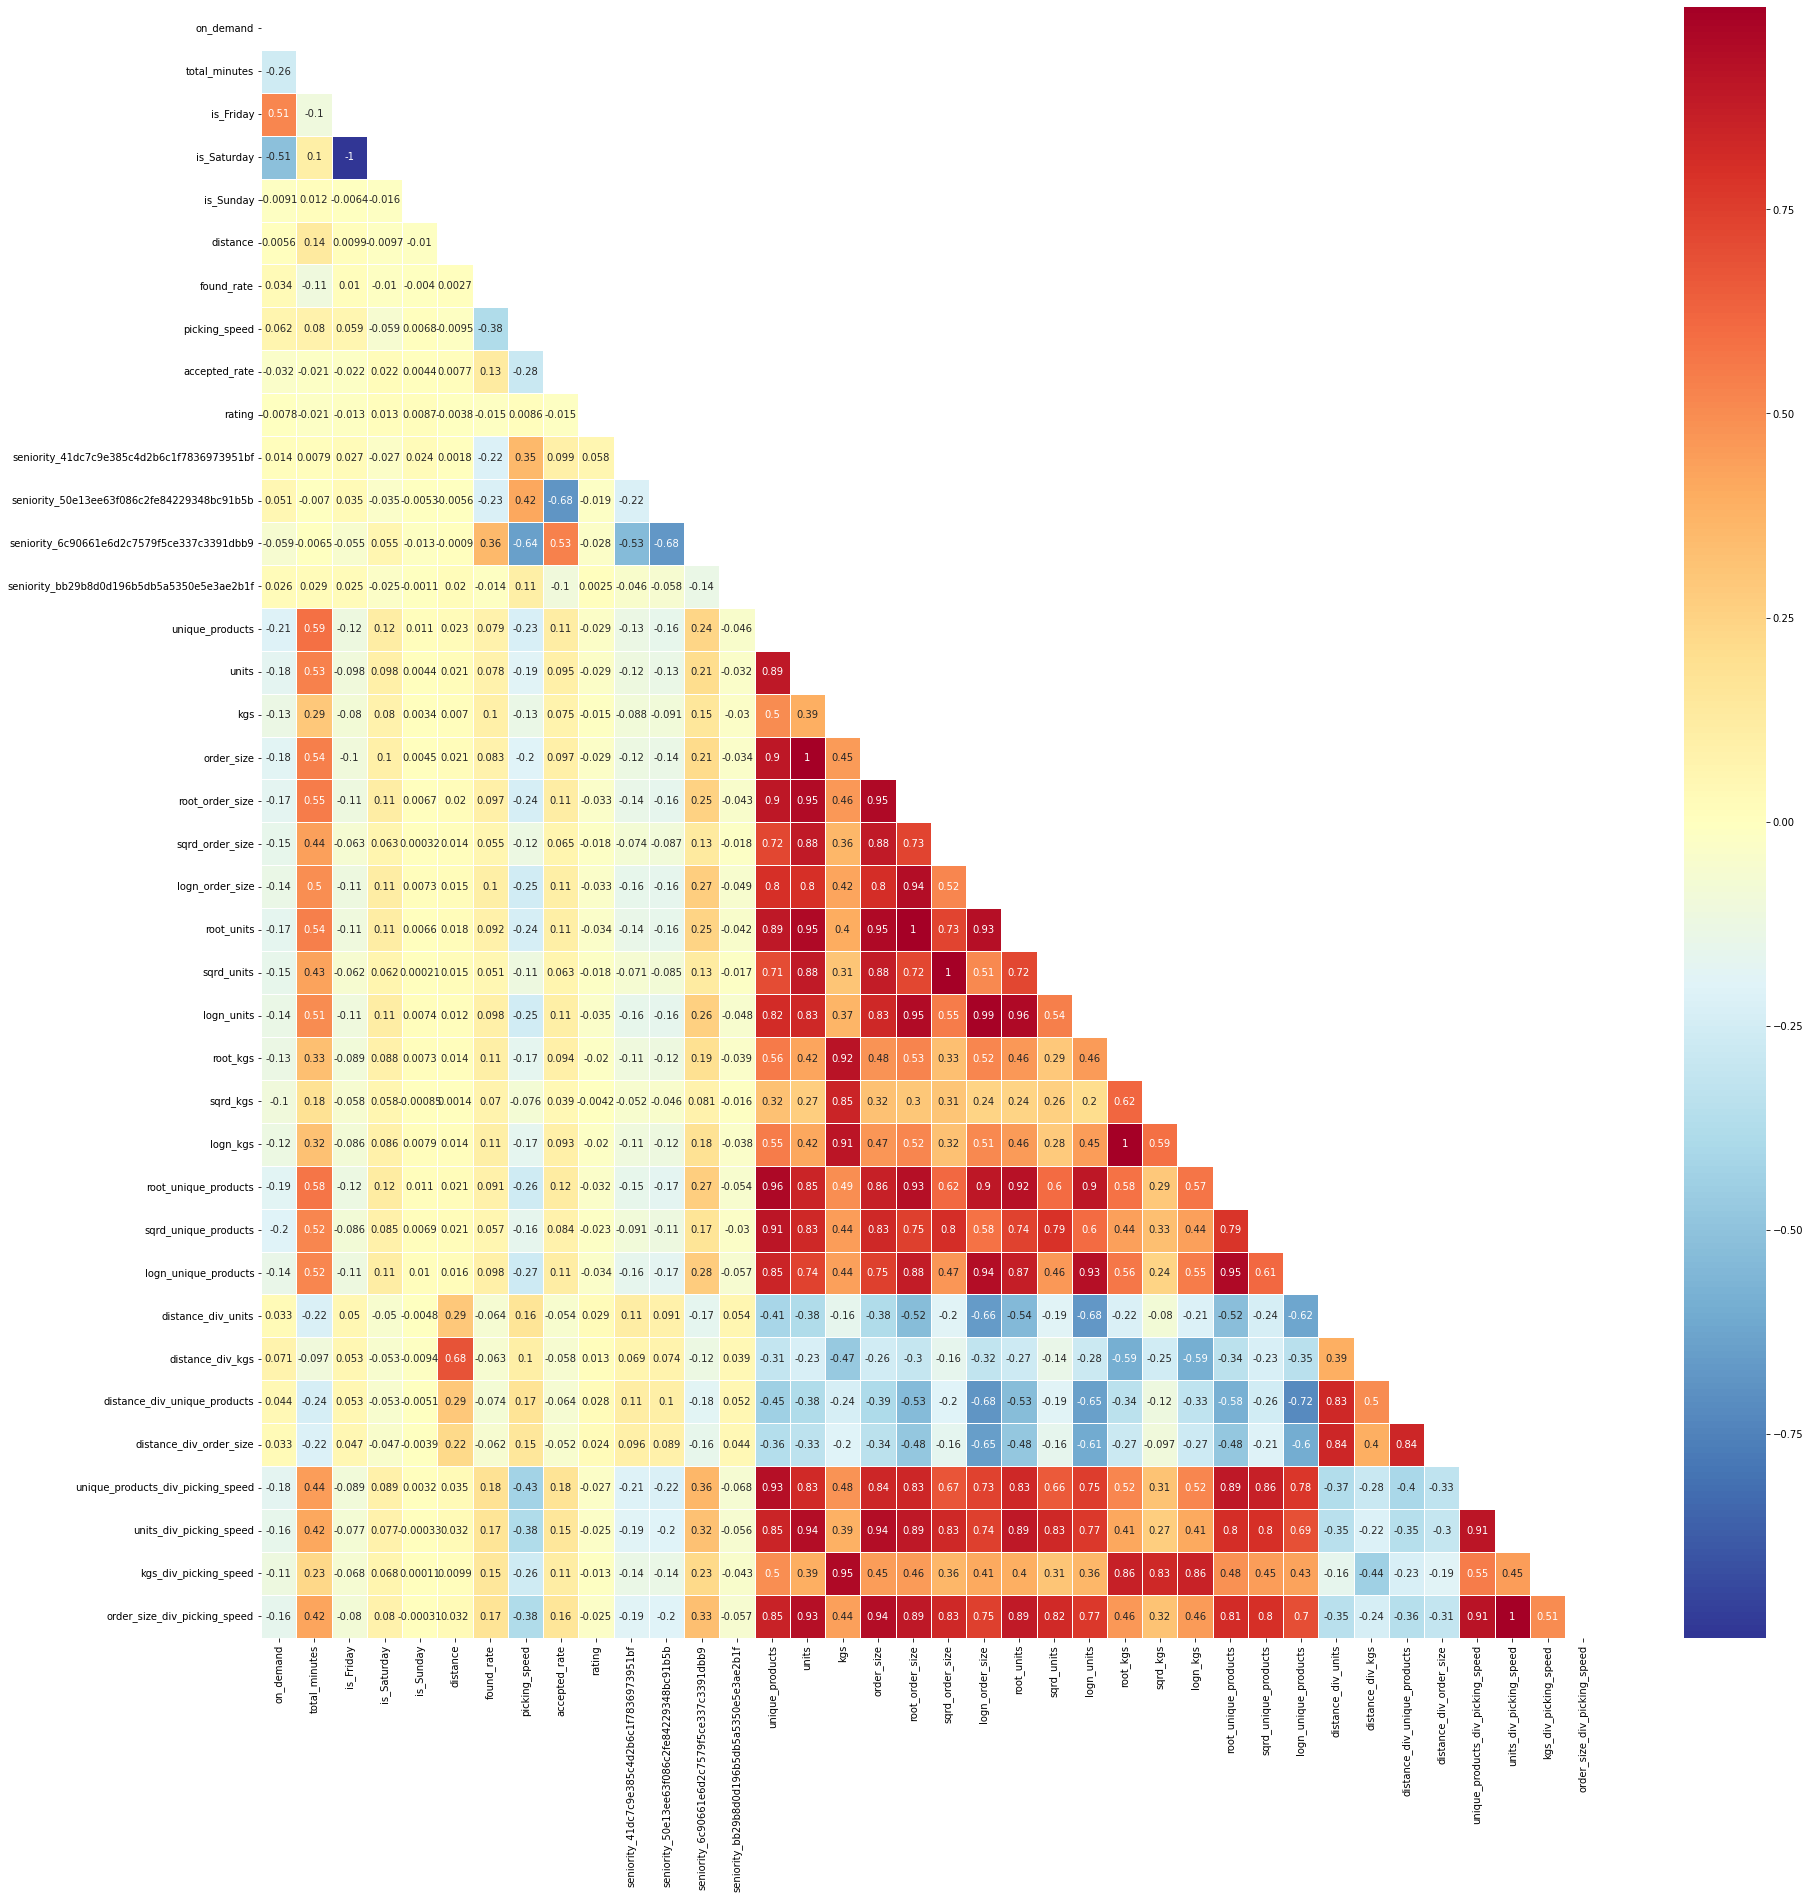

In [34]:
plt.figure(figsize=(30, 30))
heatmap(data.corr(), annot=True, linewidth=.8, mask=np.triu(data.corr()), cmap="RdYlBu_r")

In [35]:
data.min(), data.max()

(on_demand                                      0.000000
 total_minutes                                 11.969489
 is_Friday                                      0.000000
 is_Saturday                                    0.000000
 is_Sunday                                      0.000000
 distance                                       0.076566
 found_rate                                     0.737300
 picking_speed                                  0.650000
 accepted_rate                                  0.240000
 rating                                         3.880000
 seniority_41dc7c9e385c4d2b6c1f7836973951bf     0.000000
 seniority_50e13ee63f086c2fe84229348bc91b5b     0.000000
 seniority_6c90661e6d2c7579f5ce337c3391dbb9     0.000000
 seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f     0.000000
 unique_products                                1.000000
 units                                          0.000000
 kgs                                            0.000000
 order_size                    

## Split NaN for later submission

https://stackoverflow.com/a/34298165

In [36]:
no_nan = data.dropna()  # No NaN Values in no_nan
submission = data[~data.index.isin(no_nan.index)]
data.dropna(inplace=True)
del no_nan
data.shape, submission.shape


((7983, 38), (1995, 38))

## Outliers

In [37]:
data.describe()

,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,...,sqrd_unique_products,logn_unique_products,distance_div_units,distance_div_kgs,distance_div_unique_products,distance_div_order_size,unique_products_div_picking_speed,units_div_picking_speed,kgs_div_picking_speed,order_size_div_picking_speed
count,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.00000,...,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000
mean,0.454591,81.152277,0.290367,0.709508,0.000125,2.885621,0.863329,1.689766,0.916618,4.85085,...,665.878241,2.539972,0.268897,1.750063,0.465526,0.343558,13.849294,24.028308,1.209787,25.238095
std,0.497965,34.705843,0.453960,0.454018,0.011192,1.831026,0.029570,0.630342,0.097250,0.12615,...,1145.674612,1.096942,0.522099,1.574339,0.864323,0.779217,13.106805,25.578459,1.926248,26.502909
min,0.000000,11.969489,0.000000,0.000000,0.000000,0.076566,0.737300,0.650000,0.240000,3.88000,...,1.000000,0.000000,0.000845,0.014227,0.002254,0.000850,0.167224,0.000000,0.000000,0.072464
25%,0.000000,55.301119,0.000000,0.000000,0.000000,1.587437,0.846800,1.260000,0.880000,4.80000,...,49.000000,1.945910,0.044340,0.616532,0.078036,0.043377,3.908432,5.882353,0.000000,6.394755
50%,0.000000,74.752992,0.000000,1.000000,0.000000,2.500813,0.865200,1.520000,0.960000,4.88000,...,256.000000,2.772589,0.095597,1.266692,0.159633,0.093939,10.526316,16.292135,0.467128,17.314286
75%,1.000000,100.302939,1.000000,1.000000,0.000000,3.907589,0.883350,2.000000,1.000000,4.96000,...,784.000000,3.332205,0.234187,2.405159,0.381159,0.240655,19.354839,32.947861,1.655039,34.694082
max,1.000000,304.190303,1.000000,1.000000,1.000000,16.631580,0.971000,7.040000,1.000000,5.00000,...,21025.000000,4.976734,6.517985,15.236974,11.655103,18.067871,114.563107,254.368932,34.202105,258.966990


total_minutes has a max of 304.19 but a mean of 81.15 and std of 34.70 (115.85)

<AxesSubplot:>

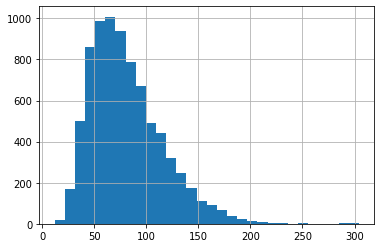

In [38]:
data.total_minutes.hist(bins=30)

In [39]:
# Show the 1% rows with highest total_minutes
print(len(data))
max_threshold_total_minutes = data.total_minutes.quantile(0.99)
print(max_threshold_total_minutes)
data[data.total_minutes > max_threshold_total_minutes]


7983
183.35082176566706


,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,...,sqrd_unique_products,logn_unique_products,distance_div_units,distance_div_kgs,distance_div_unique_products,distance_div_order_size,unique_products_div_picking_speed,units_div_picking_speed,kgs_div_picking_speed,order_size_div_picking_speed
order_id,,,,,,,,,,,,,,,,,,,,,
1fdae1d03404b1949734100c31b546fb,0,197.549007,1,0,0,3.860681,0.8193,1.78,0.96,4.80,...,8100.0,4.499810,0.021330,0.259926,0.042896,0.019916,50.561798,101.123596,7.782584,108.906180
fd54f605535d447cd9fb651c8fa0304b,1,196.349117,0,1,0,3.897032,0.8026,3.25,0.92,4.44,...,1764.0,3.737670,0.062855,0.607867,0.092786,0.058681,12.923077,18.769231,1.664923,20.434154
84f1e82d7df038e443a27c817decc889,0,234.163070,1,0,0,5.887434,0.8641,1.18,0.96,4.80,...,289.0,2.833213,0.367965,2.453097,0.346320,0.358990,14.406780,12.711864,1.186441,13.898305
c5f3e1741c152b3f095a1cdb6492eee9,0,185.821456,0,1,0,1.398650,0.8574,1.86,0.96,4.92,...,8100.0,4.499810,0.005756,0.177381,0.015541,0.005620,48.387097,130.107527,3.701613,133.809140
9894becd6717def2eaf664b50e88e7e3,0,188.391195,0,1,0,5.692355,0.8972,1.55,0.80,4.80,...,400.0,2.995732,0.196288,0.299598,0.284618,0.123747,12.903226,18.064516,11.612903,29.677419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c16dde6db6529c78761c63dec079c526,0,208.515900,0,1,0,4.714432,0.8098,3.74,0.92,4.72,...,1600.0,3.688879,0.082709,1.746086,0.117861,0.081706,10.695187,14.973262,0.454545,15.427807
65d0352da02191a18e0e823120525225,1,275.898953,1,0,0,3.789268,0.8201,2.14,0.92,4.72,...,9.0,1.098612,0.631545,3.789268,1.263089,0.757854,1.401869,2.336449,0.000000,2.336449
01ad1ee63bf577c4d54b62eb14faac74,0,258.377476,0,1,0,0.719943,0.8658,3.75,0.72,4.80,...,2209.0,3.850148,0.003380,0.719943,0.015318,0.003396,12.533333,56.533333,0.000000,56.533333


7903


<AxesSubplot:>

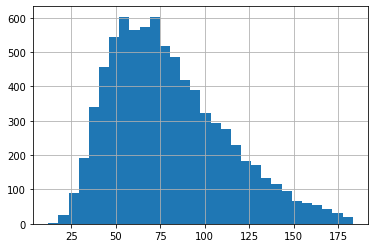

In [40]:
# Remove the 1% highest values for total_minutes from data
data = data[data.total_minutes < max_threshold_total_minutes]
print(len(data))
data.total_minutes.hist(bins=30)

distance has a max value of 16.63km, a mean of 2.88km and std of 1.83km (4.71km)

<AxesSubplot:>

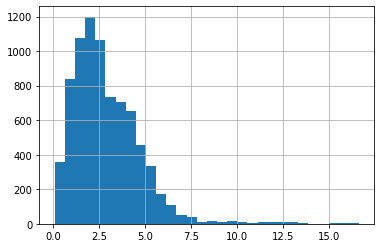

In [41]:
data.distance.hist(bins=30)

In [42]:
# Show the 1% rows with highest distance
max_threshold_distance = data.distance.quantile(0.99)
print(max_threshold_distance)
data[data.distance > max_threshold_distance]

9.529930723162044


,on_demand,total_minutes,is_Friday,is_Saturday,is_Sunday,distance,found_rate,picking_speed,accepted_rate,rating,...,sqrd_unique_products,logn_unique_products,distance_div_units,distance_div_kgs,distance_div_unique_products,distance_div_order_size,unique_products_div_picking_speed,units_div_picking_speed,kgs_div_picking_speed,order_size_div_picking_speed
order_id,,,,,,,,,,,,,,,,,,,,,
7b3269141f2704114bfe50a76b389e0d,0,132.103300,0,1,0,9.690535,0.870700,1.92,0.956522,4.800000,...,1600.0,3.688879,0.127507,0.902873,0.242263,0.114366,20.833333,39.062500,5.069271,44.131771
a886c1ecaa7bc020586121bae443cde5,1,119.980312,1,0,0,14.373572,0.829700,2.61,0.880000,4.920000,...,100.0,2.302585,1.306688,14.373572,1.437357,1.437357,3.831418,3.831418,0.000000,3.831418
ff39aa4747d0df52912ac81c175fbabe,0,102.282521,1,0,0,10.220581,0.878400,1.17,0.920000,4.760000,...,676.0,3.258097,0.222187,2.640977,0.393099,0.213507,22.222222,38.461538,2.452991,40.914530
ed337bc878dbbd4545b30c14bf1a72e4,1,132.961740,1,0,0,9.608781,0.825700,2.49,0.920000,4.880000,...,196.0,2.639057,0.600549,5.434831,0.686342,0.609385,5.622490,6.024096,0.308434,6.332530
0451ce35950f0bcb2b41cbc824c7e3a6,1,64.817211,1,0,0,15.610490,0.861082,2.19,1.000000,5.000000,...,16.0,1.386294,3.902622,5.203497,3.902622,3.122098,1.826484,1.369863,0.913242,2.283105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e3796d0a592e88d165e4181e7cdc0ab6,0,61.577879,1,0,0,12.921190,0.895400,1.07,0.920000,4.680000,...,729.0,3.295837,0.340031,3.814937,0.478563,0.328057,25.233645,34.579439,2.230841,36.810280
7657e46a8c82baf46209f4b30ace6124,1,110.836691,1,0,0,10.138255,0.883000,0.97,1.000000,4.800000,...,1225.0,3.555348,0.235773,2.762467,0.289664,0.226959,36.082474,43.298969,2.752577,46.051546
b8c05693696e17c89bd09020b97d6605,1,136.385140,1,0,0,11.231542,0.857100,2.83,0.920000,4.920000,...,625.0,3.218876,0.167635,2.497008,0.449262,0.161610,8.833922,23.321555,1.236042,24.557597


![alt text](santiago.png "Title")

15km radius

7823


<AxesSubplot:>

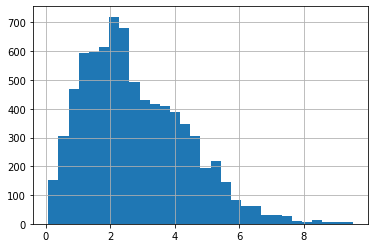

In [43]:
# Remove the 1% highest values for distance from data
data = data[data.distance < max_threshold_distance]
print(len(data))
data.distance.hist(bins=30)

## Write csv

In [45]:
# Save data and submission to disk
data.to_csv('data.csv')
submission.to_csv('submission_data.csv')